# SQLAlchemy Homework - Surfs Up!

## Import Dependencies

In [1]:
%matplotlib inline

In [2]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt
# from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# View the columns associated with the table
Measurement.__table__.columns.values()

[Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<measurement>),
 Column('date', TEXT(), table=<measurement>),
 Column('prcp', FLOAT(), table=<measurement>),
 Column('tobs', FLOAT(), table=<measurement>)]

In [9]:
# If you just want a list of the column headers, run:
Measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [10]:
# If you just want a list of the column headers, run:
Station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [35]:
# Retrieve the most recent meas data
date_last_meas_str = session.query(func.max(Measurement.date))

# Convert the data from string to datetime
date_last_meas_object = dt.datetime.strptime(date_last_meas_str.first()[0], '%Y-%m-%d').date()

# Create a query data interval
query_date = date_last_meas_object - dt.timedelta(days=365)

# Query the database based on the target date (last 365 days)
precipitation_query= session.query(Measurement.date,
                                   Measurement.prcp,
                                  ).filter(Measurement.date > query_date).all()

In [39]:
# Load the query results into a Pandas DataFrame and set the index to the date column.
precipitation_12_months = pd.DataFrame(precipitation_query).set_index('date', drop=True)

# Sort the DataFrame values by date
precipitation_12_months.sort_values('date',inplace=True)

In [73]:
precipitation_12_months_cleaned

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


In [46]:
# Drop the NAN values
precipitation_12_months_cleaned = precipitation_12_months.loc[precipitation_12_months['prcp'].isnull()==False]

<Figure size 432x288 with 0 Axes>

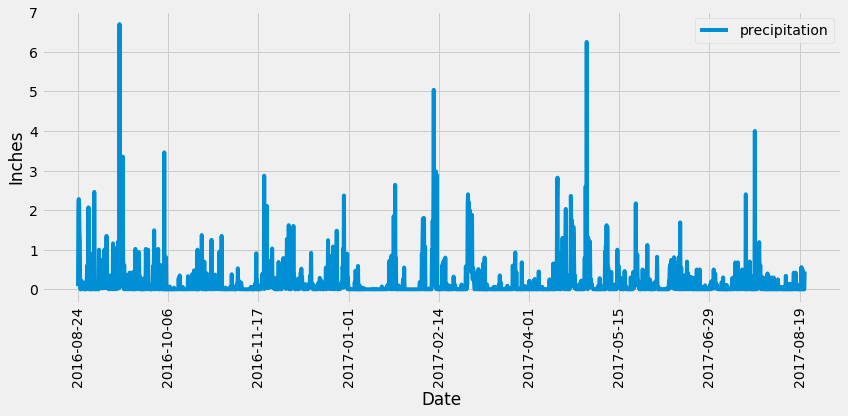

In [77]:
# Plot the results using the DataFrame plot method
plt.figure()
ax = precipitation_12_months_cleaned.plot(figsize=(12,6),rot=90)
ax.set_ylabel('Inches')
ax.set_xlabel('Date')
ax.legend(["precipitation"]);
plt.tight_layout()
plt.savefig('precipitation.png')

In [14]:


# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data

In [16]:
# Design a query to show how many stations are available in this dataset?


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`
